In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [6]:
df = pd.read_csv('cleaned_amazon_delivery.csv')
df.head()

,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,distance_km,order_dayofweek,order_month,is_weekend,order_hour,is_rush_hour
0,37,4.9,Sunny,High,motorcycle,Urban,120,Clothing,3.025149,5,3,1,11,0
1,34,4.5,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.183530,4,3,0,19,1
2,23,4.4,Sandstorms,Low,motorcycle,Urban,130,Sports,1.552758,5,3,1,8,1
3,38,4.7,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401,1,4,0,18,1
4,32,4.6,Cloudy,High,scooter,Metropolitian,150,Toys,6.210138,5,3,1,13,0


In [7]:
df_enc = df.copy()

In [8]:
from sklearn.preprocessing import LabelEncoder
cat_col = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']

le = LabelEncoder()
for col in cat_col:
    df_enc[col] = le.fit_transform(df_enc[col])


In [9]:
from sklearn.ensemble import RandomForestRegressor

X = df_enc.drop(columns=['Delivery_Time'])
y = df['Delivery_Time']

rf = RandomForestRegressor(random_state=42)
rf.fit(X,y)

importances = rf.feature_importances_

# create a dataframe of it
feat_imp = pd.DataFrame({
    'Feature':X.columns,
    'Importance':importances
}).sort_values(by='Importance', ascending=False)


In [10]:
print(feat_imp)

            Feature  Importance
6          Category    0.272304
1      Agent_Rating    0.171584
2           Weather    0.144363
7       distance_km    0.127959
0         Agent_Age    0.086072
3           Traffic    0.077993
11       order_hour    0.051692
4           Vehicle    0.026203
8   order_dayofweek    0.018970
5              Area    0.009393
9       order_month    0.008594
12     is_rush_hour    0.002445
10       is_weekend    0.002430


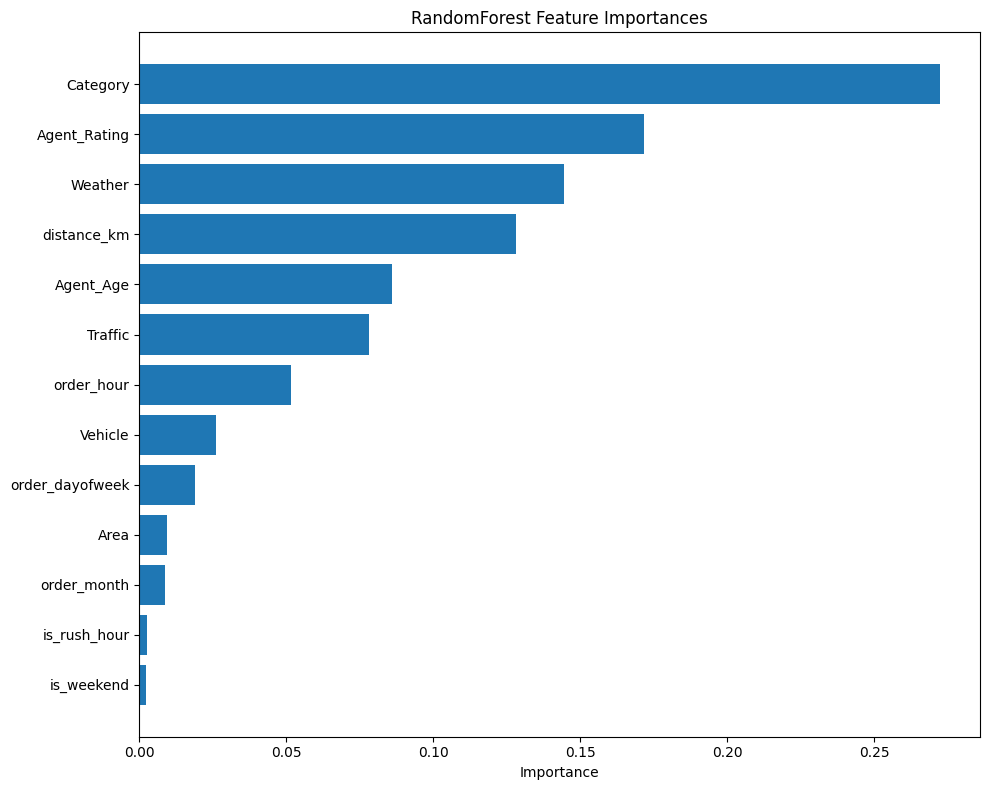

In [11]:
plt.figure(figsize=(10,8))
plt.barh(feat_imp['Feature'][::-1], feat_imp['Importance'][::-1])
plt.xlabel('Importance')
plt.title('RandomForest Feature Importances')
plt.tight_layout()
plt.show()

In [12]:
df.head(5)

,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,distance_km,order_dayofweek,order_month,is_weekend,order_hour,is_rush_hour
0,37,4.9,Sunny,High,motorcycle,Urban,120,Clothing,3.025149,5,3,1,11,0
1,34,4.5,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.183530,4,3,0,19,1
2,23,4.4,Sandstorms,Low,motorcycle,Urban,130,Sports,1.552758,5,3,1,8,1
3,38,4.7,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401,1,4,0,18,1
4,32,4.6,Cloudy,High,scooter,Metropolitian,150,Toys,6.210138,5,3,1,13,0


In [13]:
X = df.drop(columns=['Delivery_Time'])
y = df['Delivery_Time']

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

trf1 = ColumnTransformer([
    ('one_hot_vector', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), [2,3,4,5,7])
], remainder='passthrough')

In [16]:
# scaling
from sklearn.preprocessing import MinMaxScaler

trf2 = ColumnTransformer([
    ('scale', MinMaxScaler(), slice(0, 37))
])

In [17]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_regression
trf3 = SelectKBest(score_func=f_regression, k=29)

In [18]:
# Train the model
from sklearn.tree import DecisionTreeRegressor
trf4 = DecisionTreeRegressor()

In [19]:
# Create Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3),
    ('trf4', trf4)
])

In [20]:
# displaying pipe
from sklearn import set_config
set_config(display='diagram')

# Experiment Tracking with MLFlow

## 1) Model:-Decision Trees

In [24]:
import mlflow

# 1) use a short mlruns folder on C: (or any short path)
mlflow.set_tracking_uri("file:///C:/mlruns")  

# 2) set or create experiment (optional artifact_location)
mlflow.set_experiment("delivery_time_prediction")

# then run your evaluate_and_log(...) code as before
# and when logging the model prefer the 'name' parameter:
# mlflow.sklearn.log_model(pipe, name="decision_tree_pipeline")

2025/10/04 12:33:32 INFO mlflow.tracking.fluent: Experiment with name 'delivery_time_prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/mlruns/251885329141119202', creation_time=1759561412552, experiment_id='251885329141119202', last_update_time=1759561412552, lifecycle_stage='active', name='delivery_time_prediction', tags={}>

In [25]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_and_log(pipe, X_train, y_train, X_test, y_test, run_name="baseline_run"):
    with mlflow.start_run(run_name=run_name):
        # --- Fit model ---
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        
        # --- Metrics ---
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        
        # --- Log metrics ---
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        
        # --- Log model (whole pipeline) ---
        mlflow.sklearn.log_model(pipe, "decision_tree_pipeline")
        
        print(f"R²={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}")


In [32]:
evaluate_and_log(pipe, X_train, y_train, X_test, y_test, run_name="decision_tree_baseline")

2025/10/04 14:38:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 14:38:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


R²=0.252, MAE=34.32, RMSE=44.91


In [27]:
from sklearn.model_selection import cross_val_score

with mlflow.start_run(run_name="cv_run"):
    r2_cv = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()
    rmse_cv = -cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    
    mlflow.log_metric("CV_R2", r2_cv)
    mlflow.log_metric("CV_RMSE", rmse_cv)


C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories wi

In [29]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'trf4__max_depth': [3,4,5,6,7,8,10,15,None],
    'trf4__min_samples_split': [2,5,10,20],
    'trf4__min_samples_leaf': [1,2,4,6]
}

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    n_iter=20, 
    cv=5,
    scoring='r2',
    random_state=42,
    n_jobs=1
)

random_search.fit(X_train, y_train)

with mlflow.start_run(run_name="decision_tree_randomsearch"):
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("Best_CV_R2", random_search.best_score_)
    mlflow.sklearn.log_model(random_search.best_estimator_, "randomsearch_decision_tree_pipeline")


C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\Deepam Shah\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories wi

In [35]:
# assume `search` is your GridSearchCV / RandomizedSearchCV / BayesSearchCV object
print("Best CV score:", random_search.best_score_)
print("Best params:", random_search.best_params_)

best_estimator = random_search.best_estimator_   # pipeline already refit by default


Best CV score: 0.26259286763114137
Best params: {'trf4__min_samples_split': 5, 'trf4__min_samples_leaf': 6, 'trf4__max_depth': 15}


In [36]:
# Refitting the model with best params
best_params = {'trf4__min_samples_split': 5,
               'trf4__min_samples_leaf': 6,
               'trf4__max_depth': 15}

pipe.set_params(**best_params)

# 2. fit on training data
pipe.fit(X_train, y_train)

# 3. evaluate on test
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_test_pred = pipe.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Test R²: {r2_test:.4f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")


from sklearn.model_selection import cross_val_score
rmse_cv = -cross_val_score(pipe, X_train, y_train, cv=5,
                          scoring='neg_root_mean_squared_error', n_jobs=1)
print("CV RMSE mean:", rmse_cv.mean())

Test R²: 0.2521
Test MAE: 34.34
Test RMSE: 44.91
CV RMSE mean: 44.598875056134645


## 2) Model:- RandomForest

In [40]:
from sklearn.ensemble import RandomForestRegressor

# update final step in pipeline
pipe.set_params(trf4=RandomForestRegressor(random_state=42, n_jobs=-1))

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_vector',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [2, 3, 4, 5, 7])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scale', MinMaxScaler(),
                                                  slice(0, 37, None))])),
                ('trf3',
                 SelectKBest(k=29,
                             score_func=<function f_regression at 0x0000020F58CD6CA0>)),
                ('trf4', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [41]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import mlflow, mlflow.sklearn

def evaluate_and_log(pipe, X_train, y_train, X_test, y_test, run_name="rf_baseline"):
    with mlflow.start_run(run_name=run_name):
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        # metrics
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        # log
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.sklearn.log_model(pipe, name="rf_pipeline")

        print(f"[{run_name}] R²={r2:.3f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

# baseline eval
evaluate_and_log(pipe, X_train, y_train, X_test, y_test, run_name="rf_baseline")

2025/10/04 15:01:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[rf_baseline] R²=0.252, MAE=34.32, RMSE=44.91


In [42]:
from sklearn.model_selection import cross_val_score

with mlflow.start_run(run_name="rf_cv"):
    r2_cv = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2", n_jobs=1).mean()
    rmse_cv = -cross_val_score(pipe, X_train, y_train, cv=5,
                               scoring="neg_root_mean_squared_error", n_jobs=1).mean()

    mlflow.log_metric("CV_R2", r2_cv)
    mlflow.log_metric("CV_RMSE", rmse_cv)
    print("CV mean R²:", r2_cv, "CV mean RMSE:", rmse_cv)


CV mean R²: 0.26272540271392514 CV mean RMSE: 44.59491070746855


In [43]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    "trf4__n_estimators": [100, 200, 300],
    "trf4__max_depth": [None, 10, 20, 30],
    "trf4__min_samples_split": [2, 5, 10],
    "trf4__min_samples_leaf": [1, 2, 4],
    "trf4__max_features": ["sqrt", "log2", None],
    "trf4__bootstrap": [True, False]
}

rf_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    n_iter=10,          
    cv=3,
    scoring="r2",
    random_state=42,
    n_jobs=1             
)

rf_search.fit(X_train, y_train)

print("Best CV R²:", rf_search.best_score_)
print("Best Params:", rf_search.best_params_)

with mlflow.start_run(run_name="rf_randomsearch"):
    mlflow.log_params(rf_search.best_params_)
    mlflow.log_metric("Best_CV_R2", rf_search.best_score_)
    mlflow.sklearn.log_model(rf_search.best_estimator_, name="rf_randomsearch_pipeline")

Best CV R²: 0.2615527865239338
Best Params: {'trf4__n_estimators': 100, 'trf4__min_samples_split': 2, 'trf4__min_samples_leaf': 4, 'trf4__max_features': None, 'trf4__max_depth': None, 'trf4__bootstrap': True}


2025/10/04 15:08:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## 3) Model:- XGBoost

In [45]:
# 0) imports
from xgboost import XGBRegressor
import mlflow, mlflow.xgboost
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# 1) set the estimator in the pipeline (pipe already exists)
pipe.set_params(trf4=XGBRegressor(random_state=42, n_jobs=4, verbosity=0))

# 2) baseline evaluate & log
def evaluate_and_log_xgb(pipe, X_train, y_train, X_test, y_test, run_name="xgb_baseline"):
    with mlflow.start_run(run_name=run_name):
        # optional: enable autolog for xgboost (logs params, metrics, model automatically)
        # mlflow.xgboost.autolog()  # uncomment if you want autolog behavior
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        mlflow.log_metric("R2", float(r2))
        mlflow.log_metric("MAE", float(mae))
        mlflow.log_metric("RMSE", float(rmse))

        # log the pipeline as an sklearn object (works even if the final estimator is XGBoost)
        mlflow.sklearn.log_model(pipe, name="xgb_pipeline")

        print(f"[{run_name}] R²={r2:.4f}, MAE={mae:.2f}, RMSE={rmse:.2f}")

# run baseline
evaluate_and_log_xgb(pipe, X_train, y_train, X_test, y_test, run_name="xgb_baseline")

2025/10/04 15:15:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[xgb_baseline] R²=0.2514, MAE=34.35, RMSE=44.93


In [46]:
from sklearn.model_selection import cross_val_score

# do CV (use n_jobs=1 if you hit parallel issues)
r2_cv = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2', n_jobs=1).mean()
rmse_cv = -cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=1).mean()

print("XGB CV mean R²:", r2_cv)
print("XGB CV mean RMSE:", rmse_cv)

# log the CV metrics in MLflow
with mlflow.start_run(run_name="xgb_cv"):
    mlflow.log_metric("CV_R2", float(r2_cv))
    mlflow.log_metric("CV_RMSE", float(rmse_cv))


XGB CV mean R²: 0.2630461096763611
XGB CV mean RMSE: 44.585242462158206


In [48]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'trf4__n_estimators': [100, 200, 400],
    'trf4__max_depth': [3, 6, 10, 15],
    'trf4__learning_rate': [0.01, 0.05, 0.1],
    'trf4__subsample': [0.6, 0.8, 1.0],
    'trf4__colsample_bytree': [0.6, 0.8, 1.0],
    'trf4__reg_alpha': [0, 0.1, 1],
    'trf4__reg_lambda': [1, 5, 10]
}

xgb_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=2,  
    verbose=1
)

# Fit (may take time)
xgb_search.fit(X_train, y_train)

print("Best CV R²:", xgb_search.best_score_)
print("Best params:", xgb_search.best_params_)

# Log best result & model to MLflow
with mlflow.start_run(run_name="xgb_randomsearch"):
    mlflow.log_params(xgb_search.best_params_)
    mlflow.log_metric("Best_CV_R2", float(xgb_search.best_score_))
    # log the best estimator pipeline
    mlflow.sklearn.log_model(xgb_search.best_estimator_, name="xgb_best_pipeline")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best CV R²: 0.26330240567525226
Best params: {'trf4__subsample': 0.6, 'trf4__reg_lambda': 10, 'trf4__reg_alpha': 1, 'trf4__n_estimators': 100, 'trf4__max_depth': 10, 'trf4__learning_rate': 0.05, 'trf4__colsample_bytree': 0.8}


2025/10/04 15:22:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
